In [ ]:
%pip install pyspark
%pip install findspark
%pip install spark-nlp
%pip install matplotlib
%pip install seaborn



In [7]:
# %%
import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql.types import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# %%
import findspark
findspark.init()
findspark.find()

'/anaconda/envs/jupyter_env/lib/python3.8/site-packages/pyspark'

# Data Cleaning

In [3]:
# %%
# Create a SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.executor.memory", "32g") \
    .config("spark.driver.memory", "32g") \
    .getOrCreate()

24/05/13 11:36:08 WARN Utils: Your hostname, bdsongscompute2 resolves to a loopback address: 127.0.0.1; using 10.0.0.4 instead (on interface eth0)
24/05/13 11:36:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/13 11:36:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/13 11:36:09 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/05/13 11:36:09 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


## Load scaled Features

In [4]:
#load scaled features
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

features_genre_df = spark.read.csv("120kData" , header=True)

In [5]:
### get subset of data

genres = features_genre_df.select("genre").distinct().rdd.flatMap(lambda x: x).collect()

In [8]:
features_genre_df.printSchema()

features = [col_name for col_name in features_genre_df.columns if col_name != "genre"]



for feature in features:
    features_genre_df = features_genre_df.withColumn(feature , col(feature).cast("double"))
    
features_genre_df.na.drop()
print(features_genre_df.count())
features_genre_df.printSchema()



root
 |-- genre: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- key: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- time_signature: string (nullable = true)
 |-- valence: string (nullable = true)

120676
root
 |-- genre: string (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- sp

## EDA

# cross-correlation

24/05/13 11:39:10 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


<Axes: >

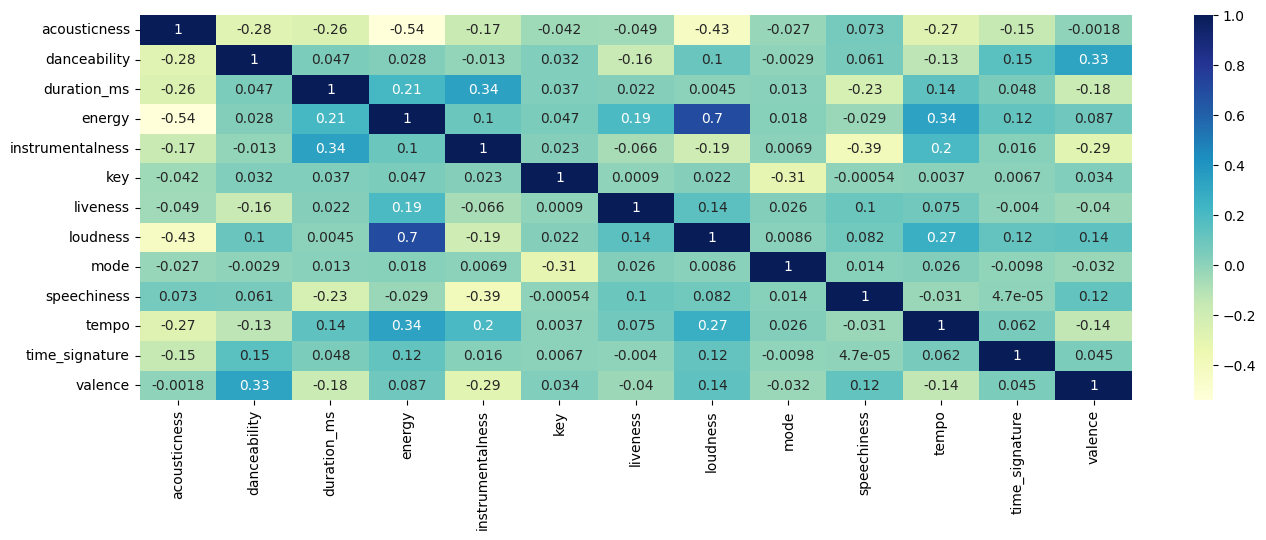

In [11]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler



# draw correlation matrix

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=features, outputCol=vector_col)
df_vector = assembler.transform(features_genre_df.select(features)).select(vector_col)

# get correlation matrix
corr_matrix_df = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray()

plt.figure(figsize=(16, 5))
sns.heatmap(
    corr_matrix_df,
    xticklabels=features,
    yticklabels=features,
    cmap="YlGnBu",
    annot=True,
)

{(0.5843137254901961, 0.4235294117647059, 0.7058823529411765), (0.9333333333333333, 0.5215686274509804, 0.2901960784313726), (0.41568627450980394, 0.8, 0.39215686274509803), (0.2823529411764706, 0.47058823529411764, 0.8156862745098039), (0.5490196078431373, 0.3803921568627451, 0.23529411764705882), (0.8392156862745098, 0.37254901960784315, 0.37254901960784315)}


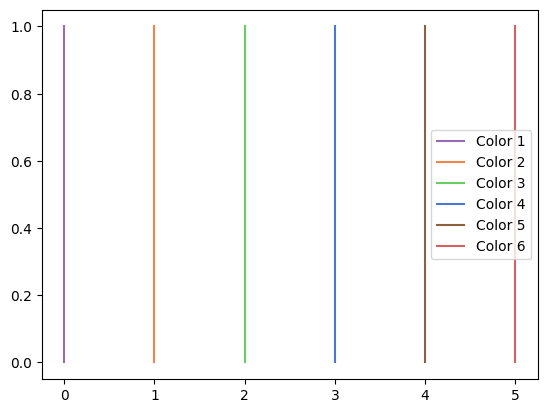

In [9]:

# Define the number of colors
num_colors = 6

# Create a list of different Seaborn color palettes
palettes = ['muted' , 'bright']

# Create a list to store the distinct colors
hex_colors = set()

# Generate colors from different palettes until we have enough distinct colors
for palette_name in palettes:
    palette = sns.color_palette(palette_name, num_colors)
    for color in palette:
        hex_colors.add(sns.palettes.color_palette([color])[0])
        if len(hex_colors) >= num_colors:
            break
    if len(hex_colors) >= num_colors:
        break

# Print the hexadecimal colors
print(hex_colors)

# Plot a sample using the colors
for i, color in enumerate(hex_colors):
    plt.plot([i, i], [0, 1], color=color, label=f'Color {i+1}')

plt.legend()
plt.show()

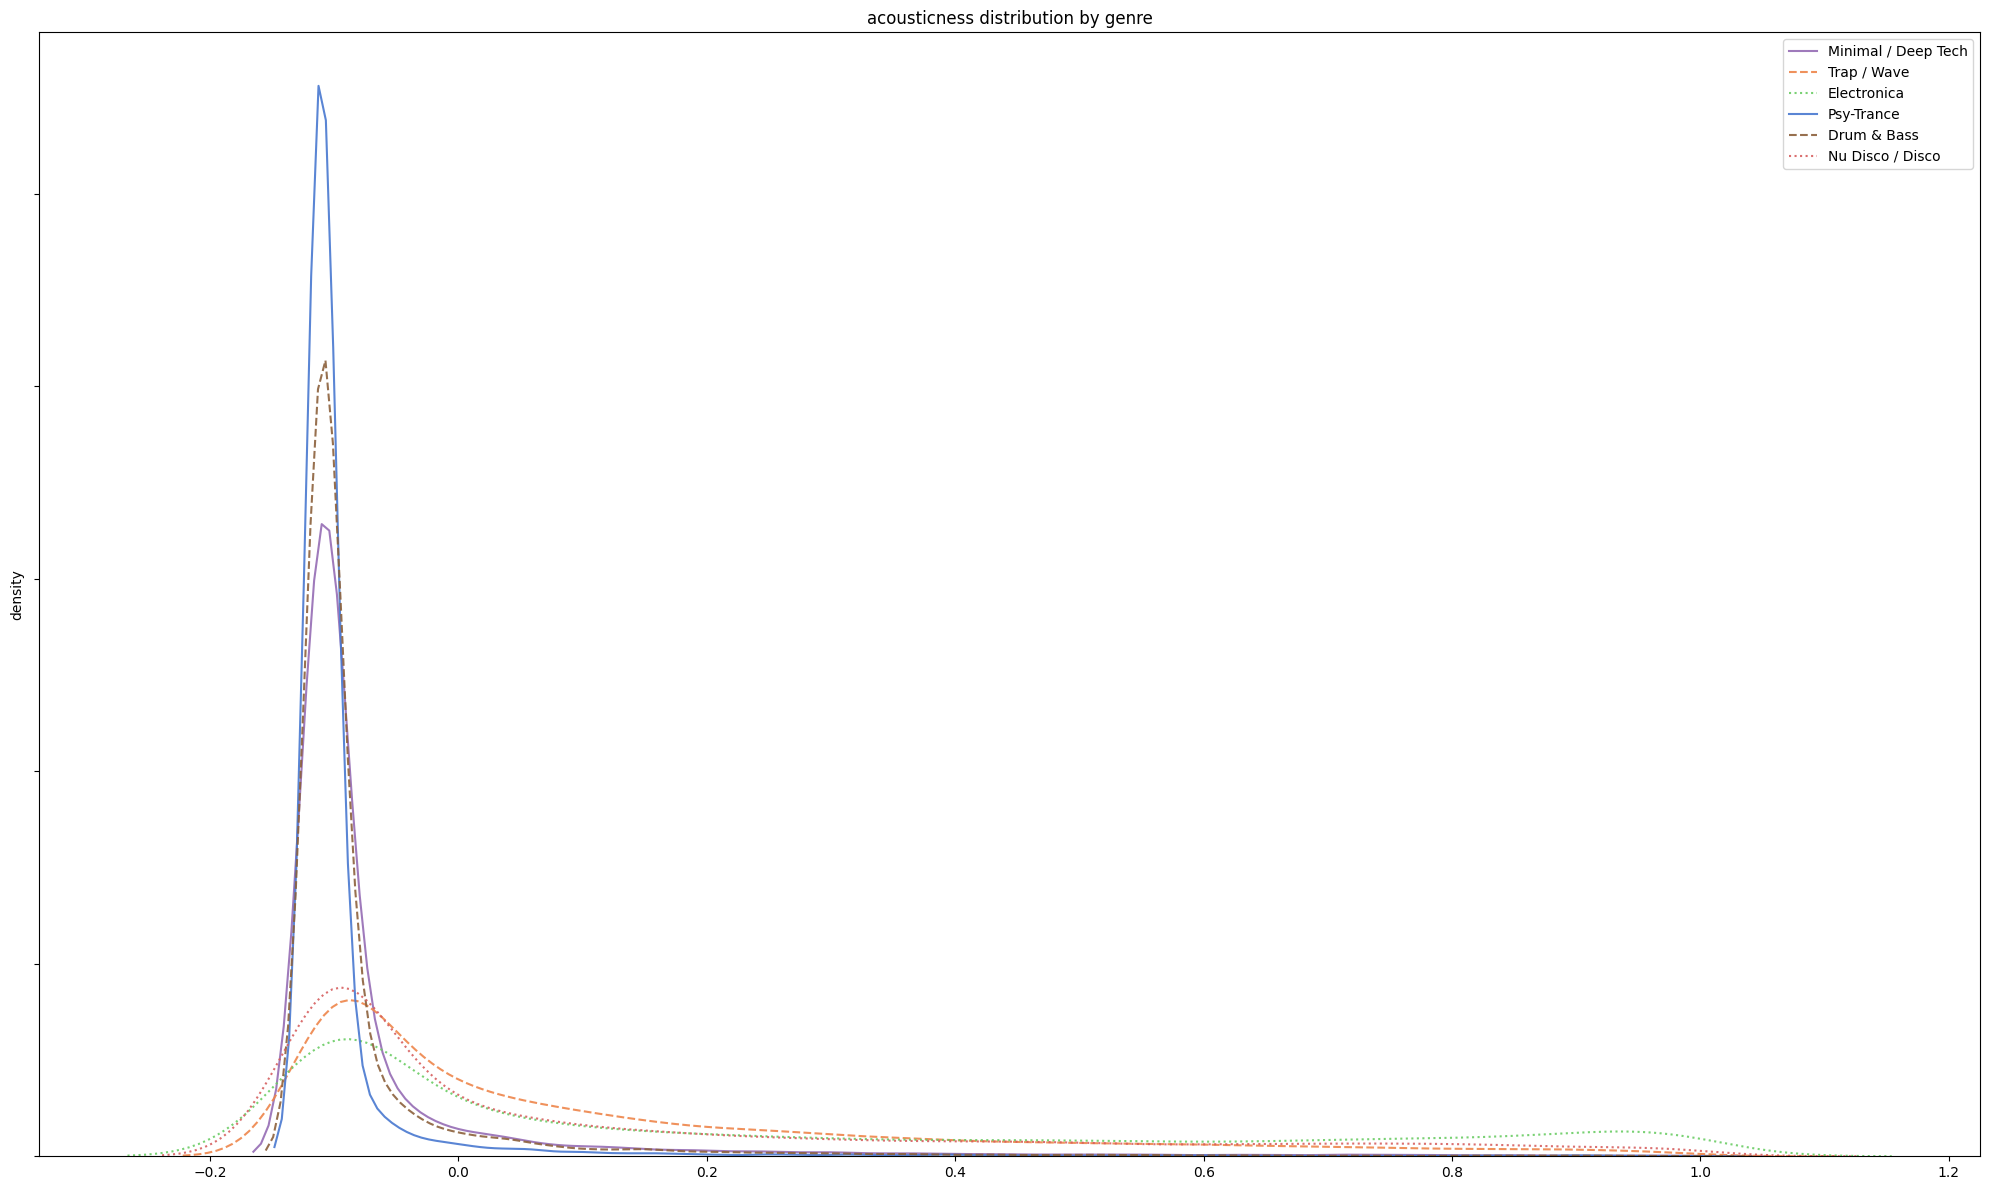

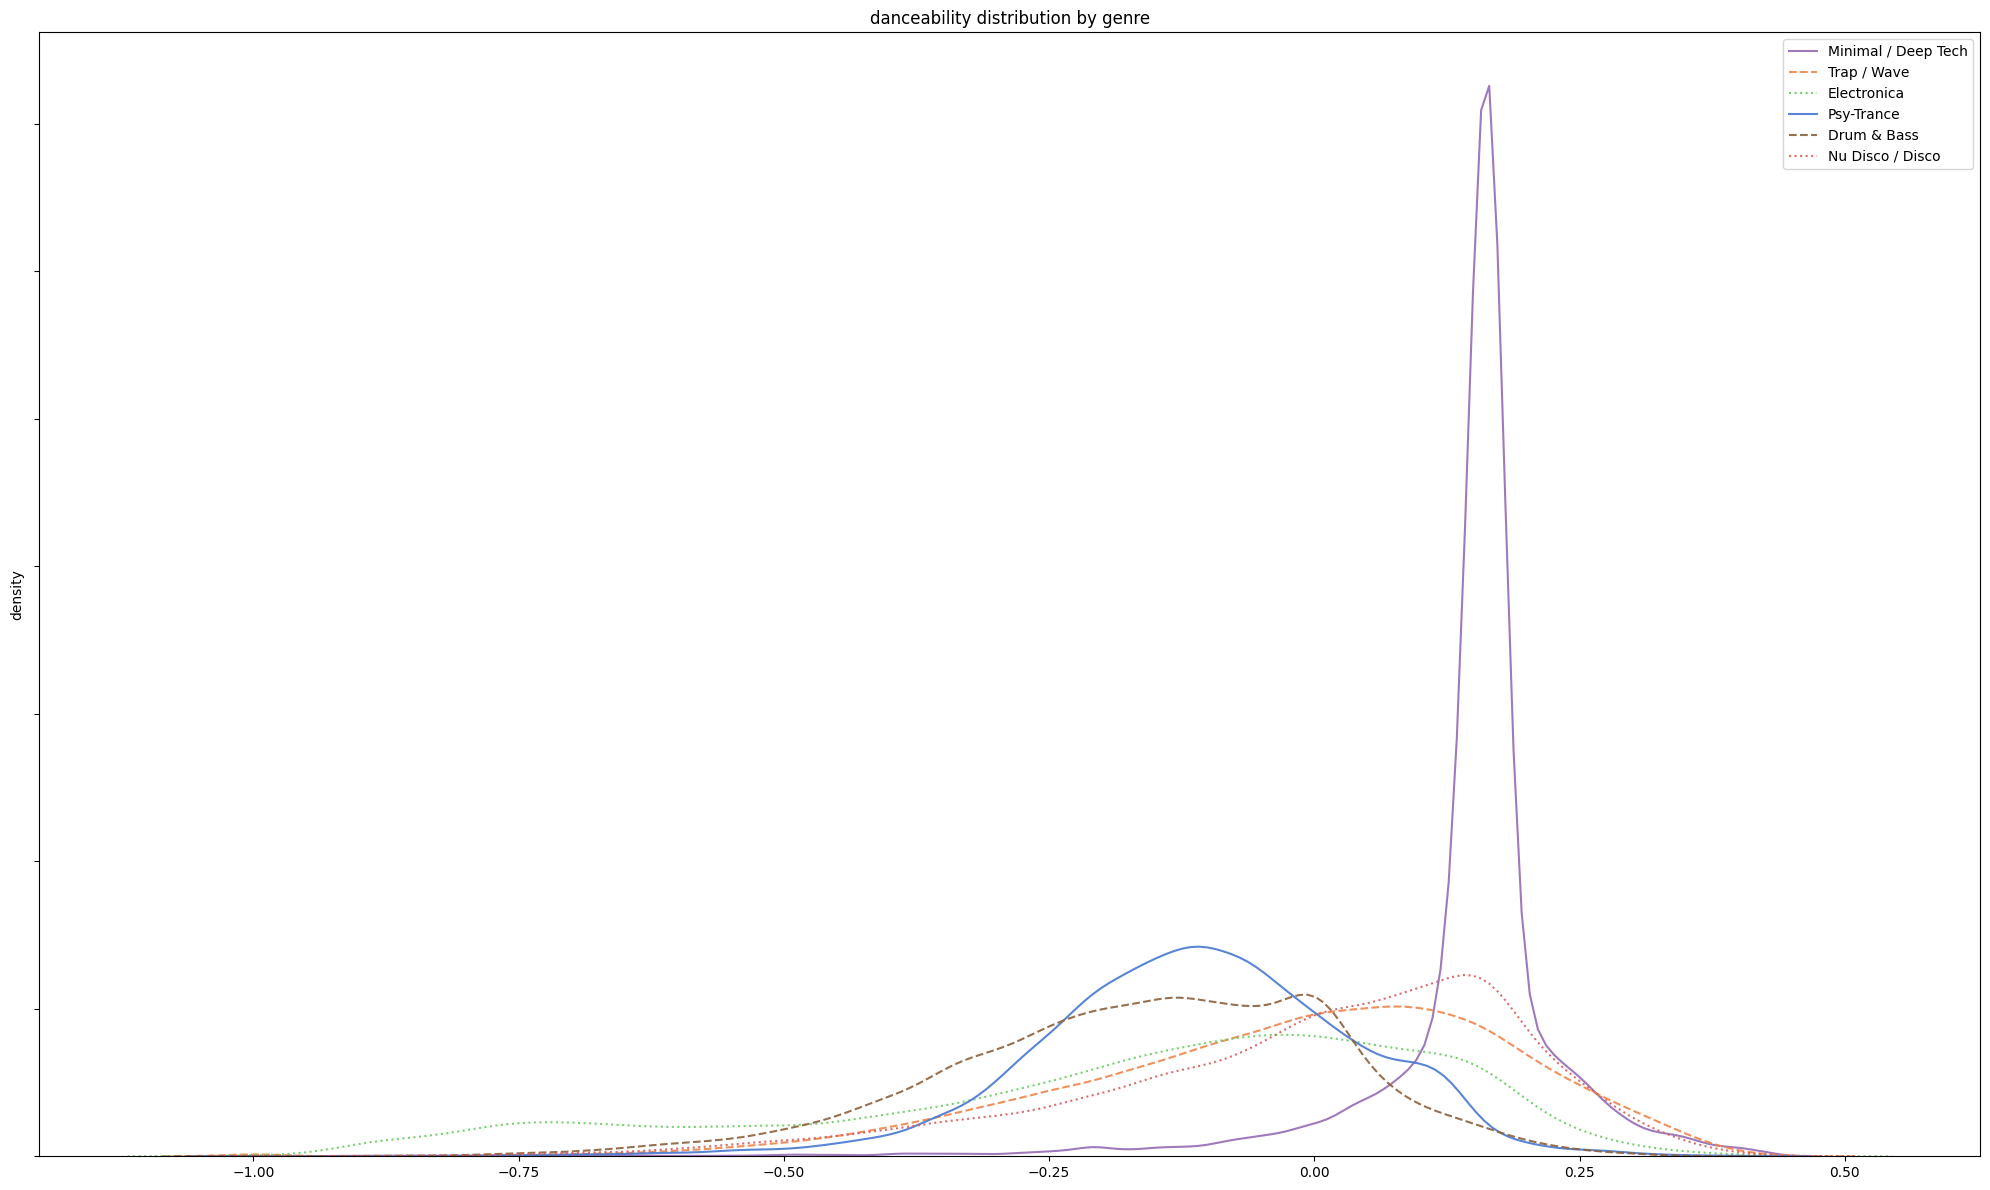

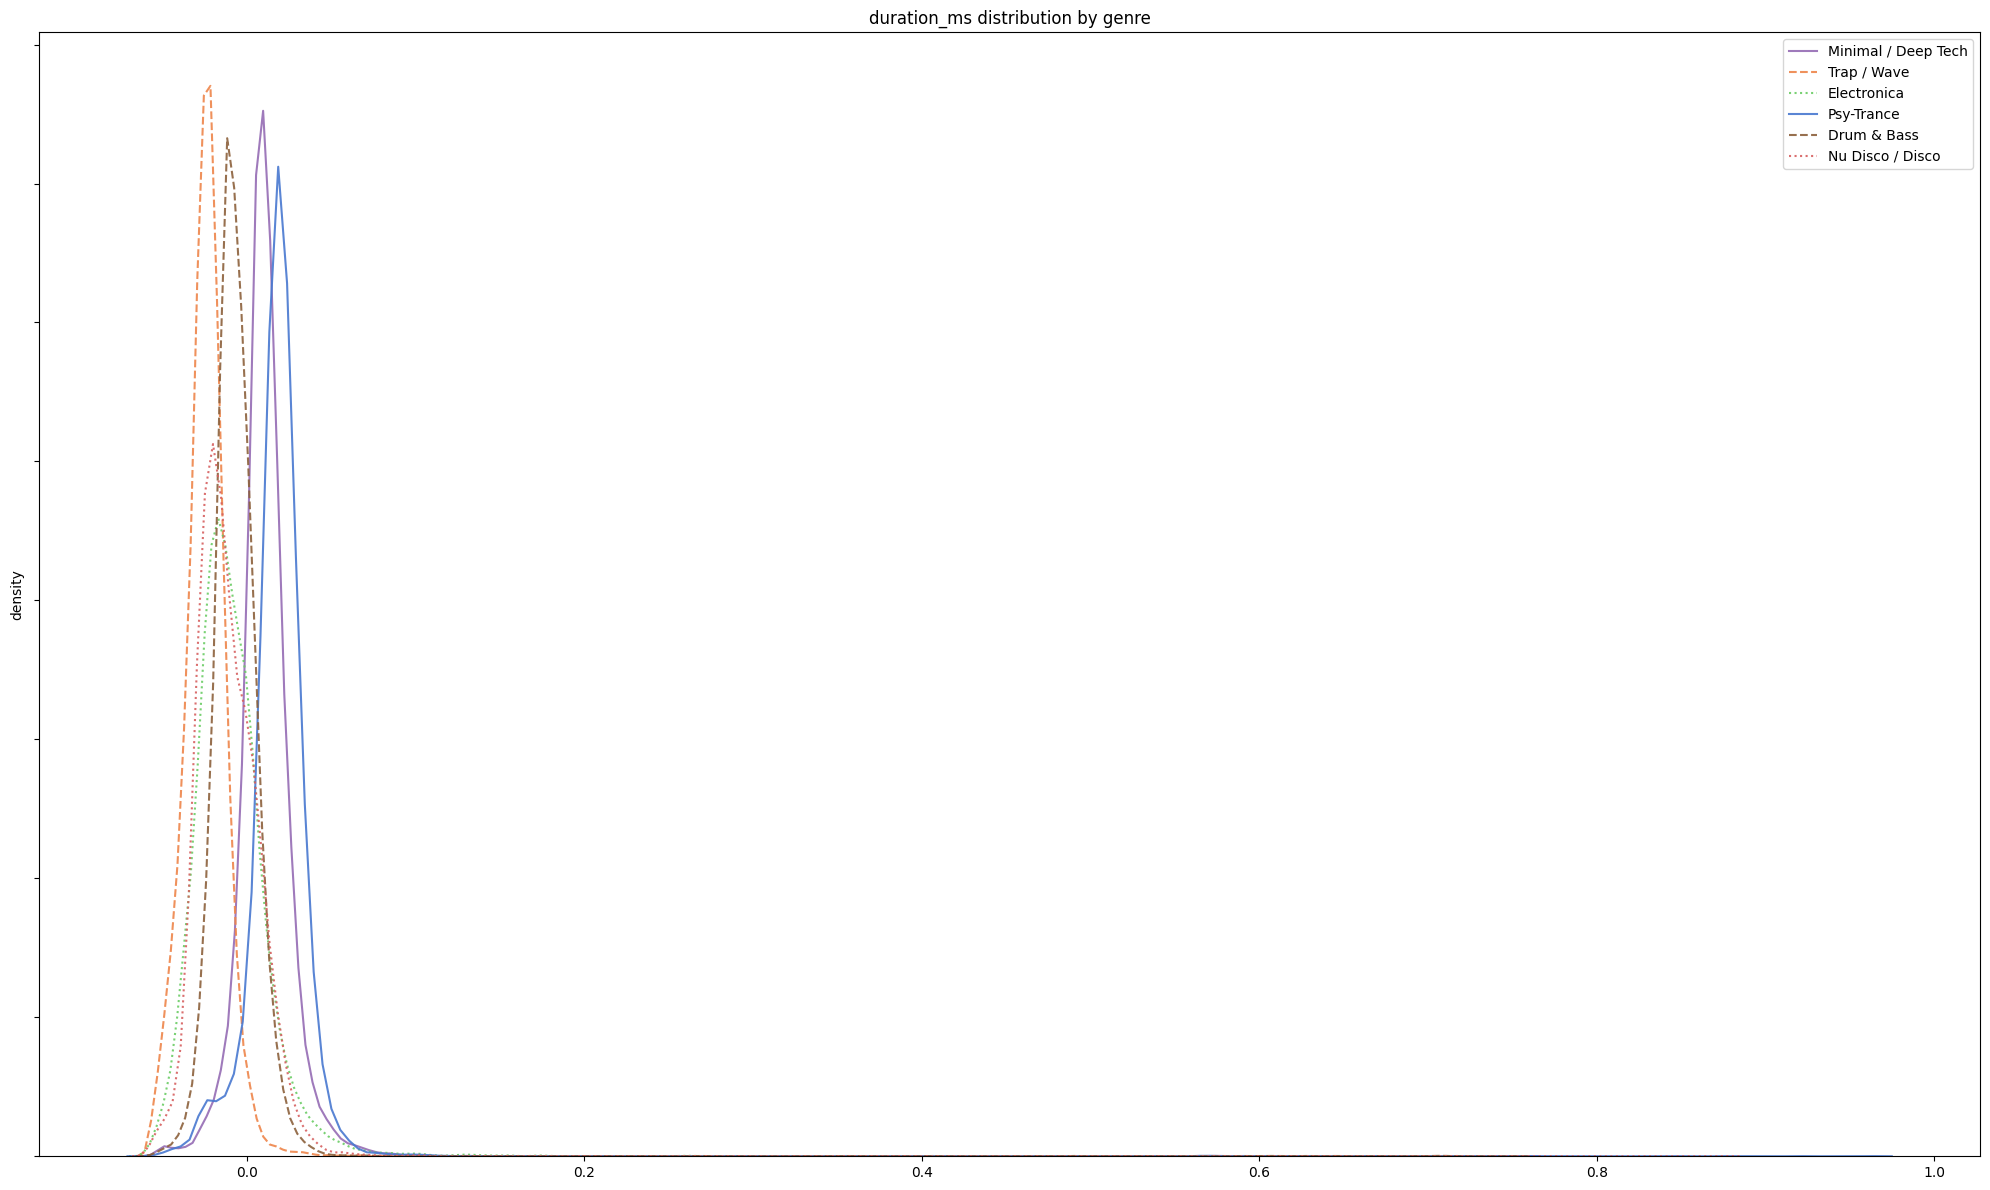

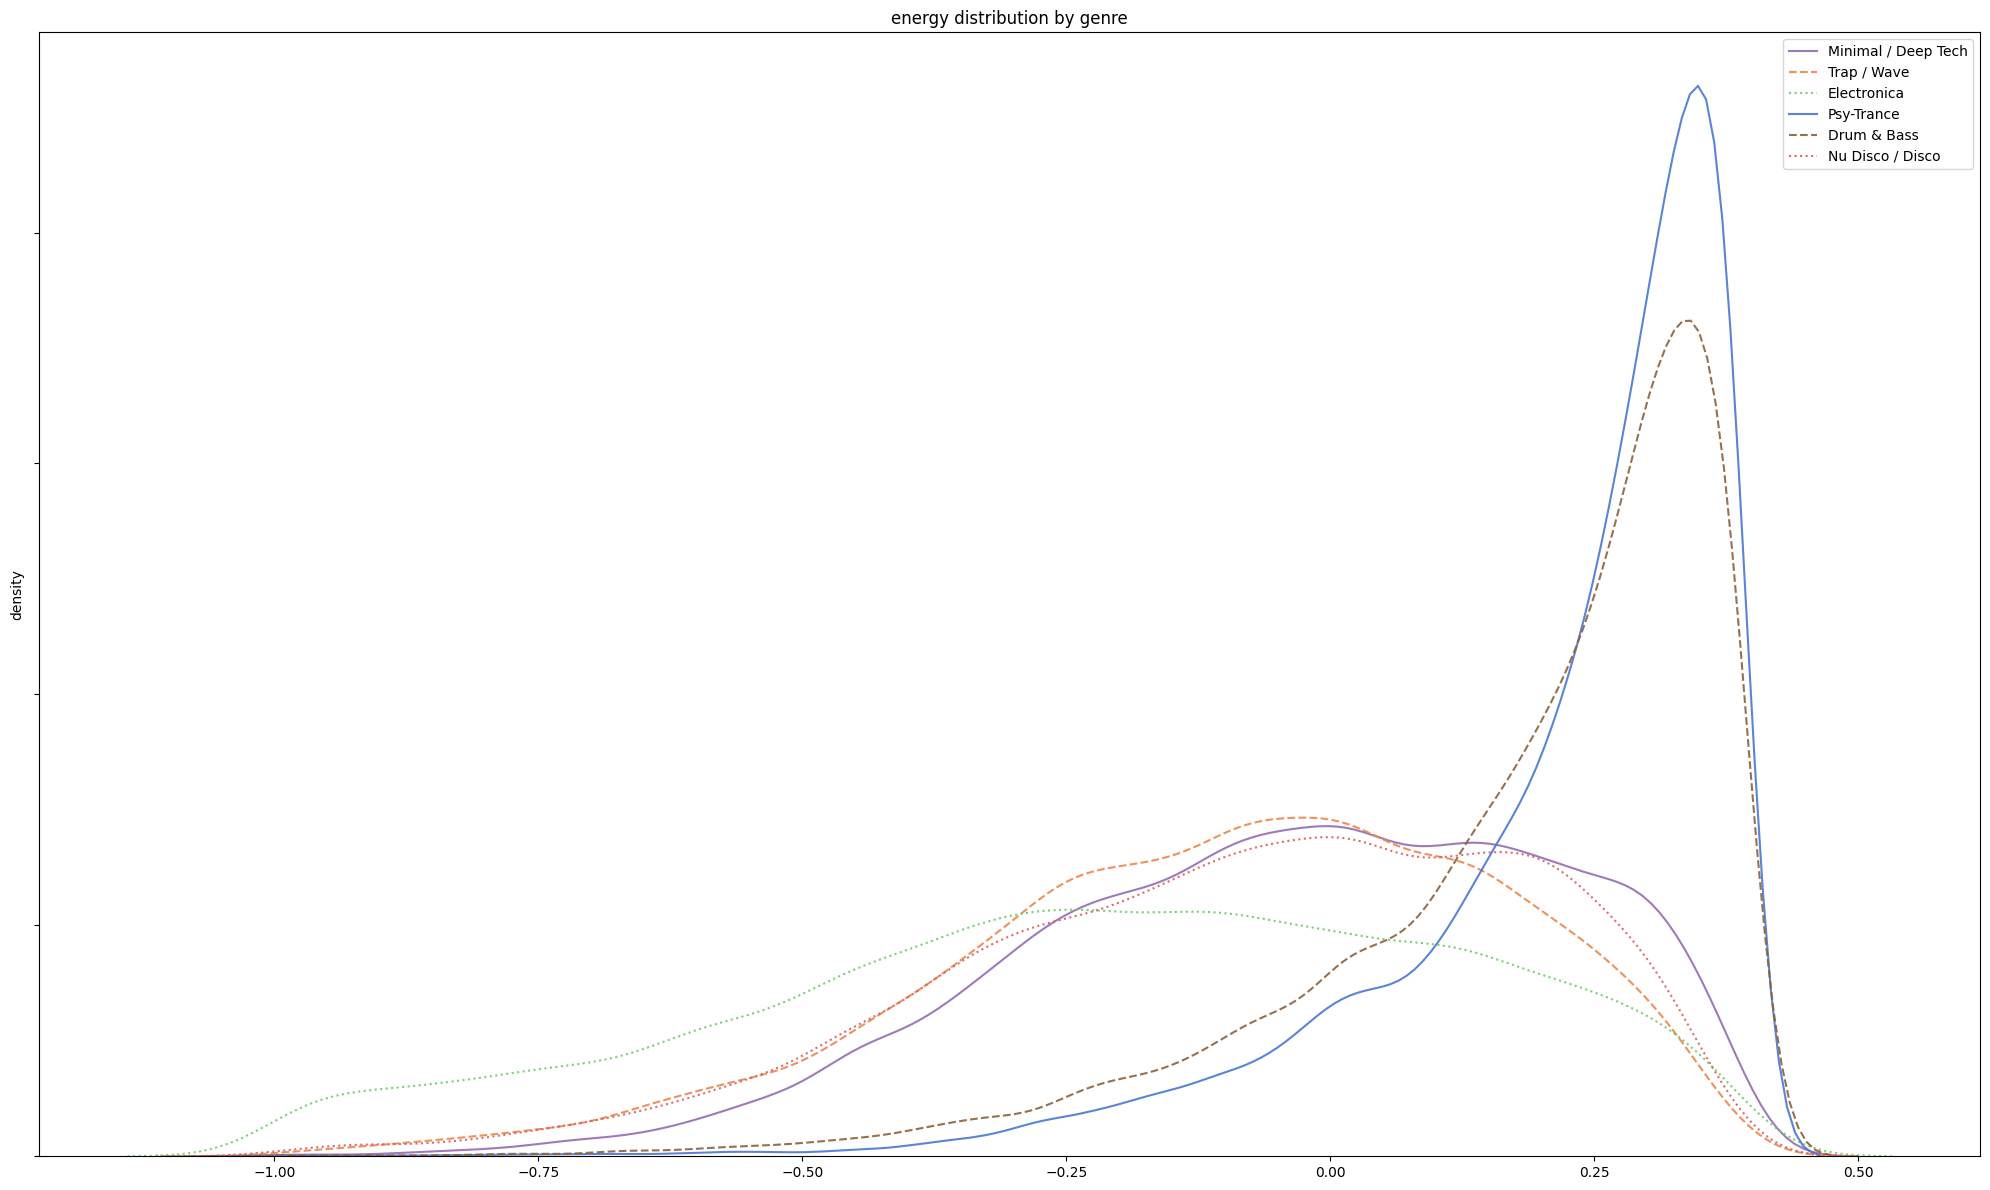

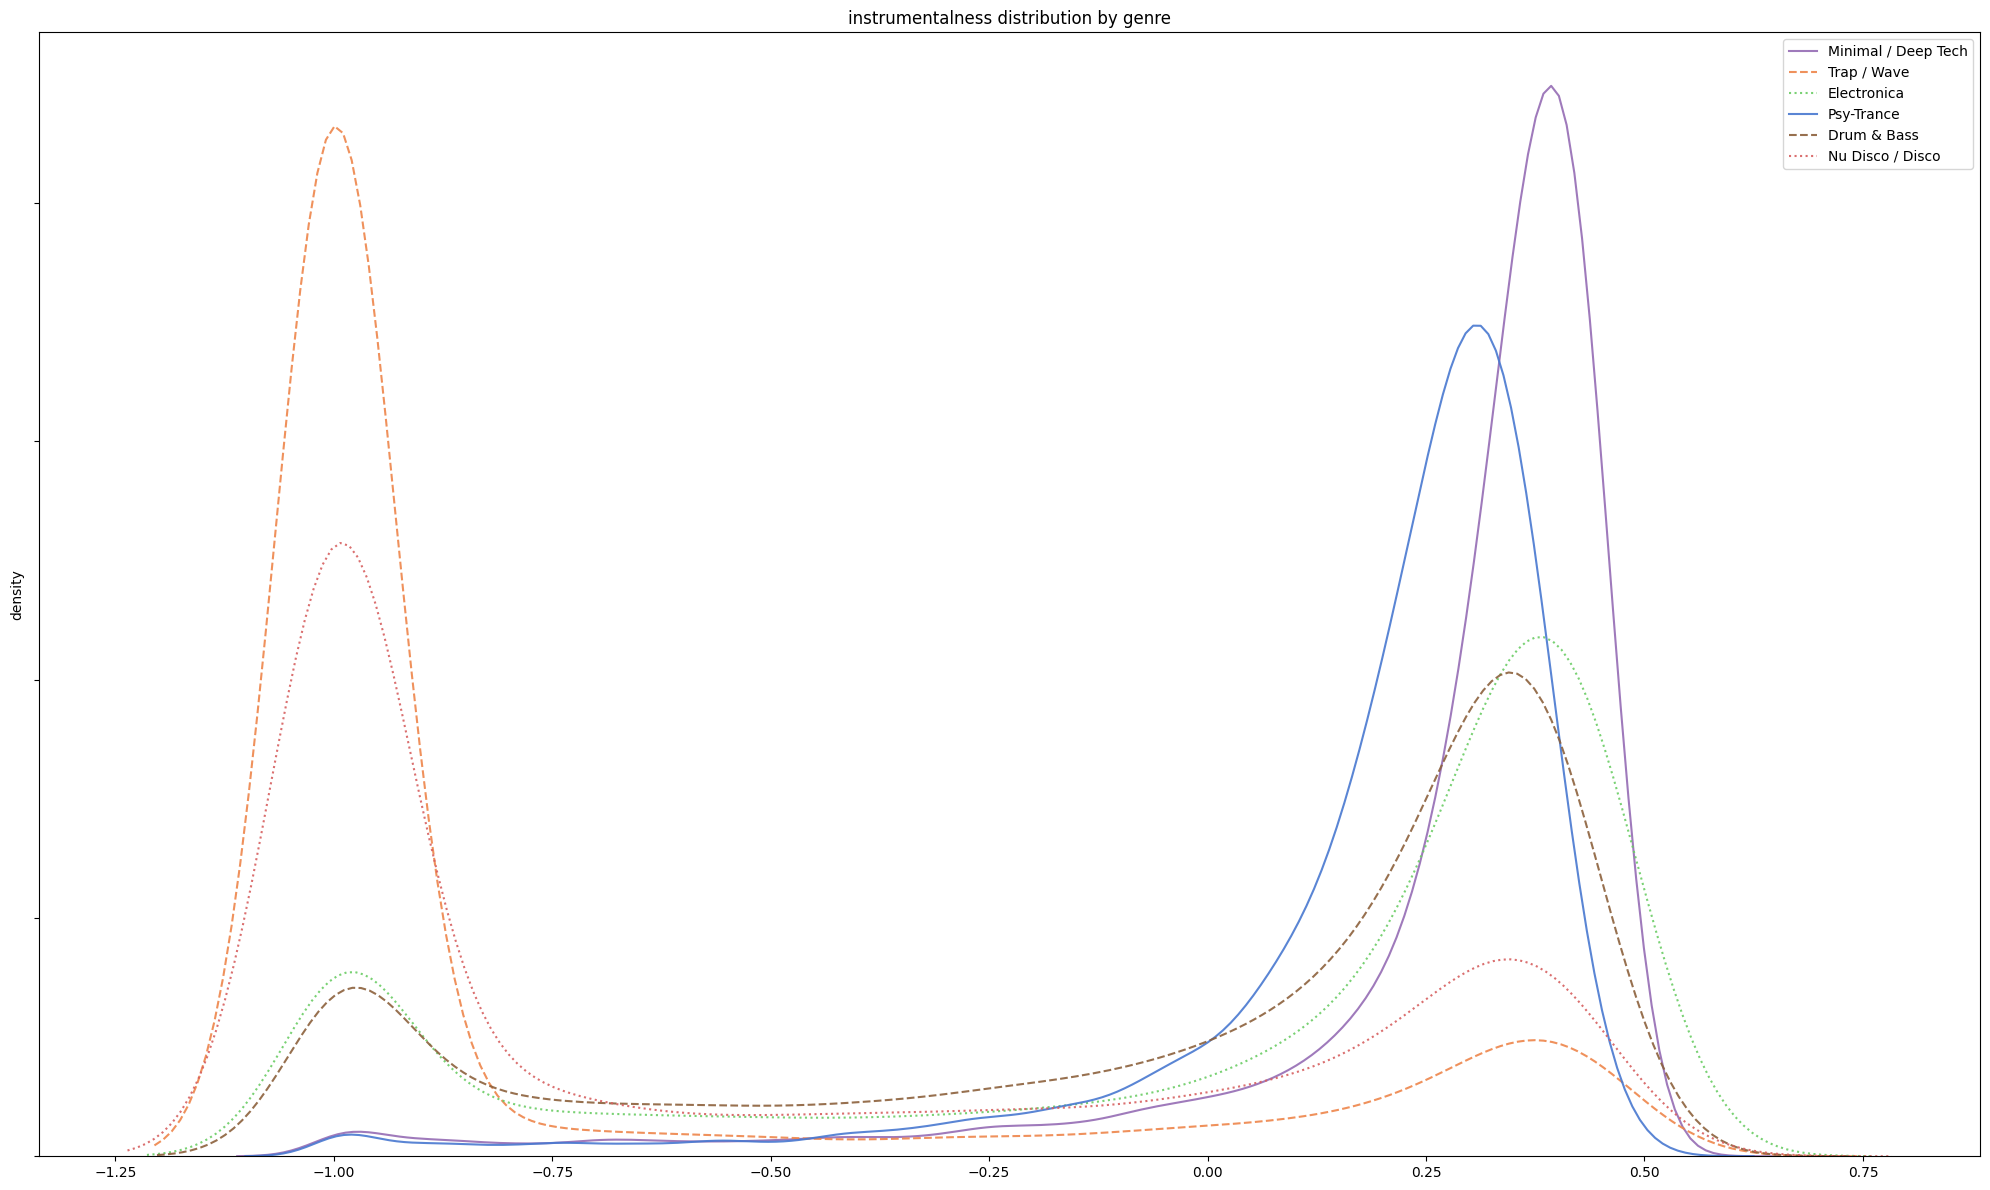

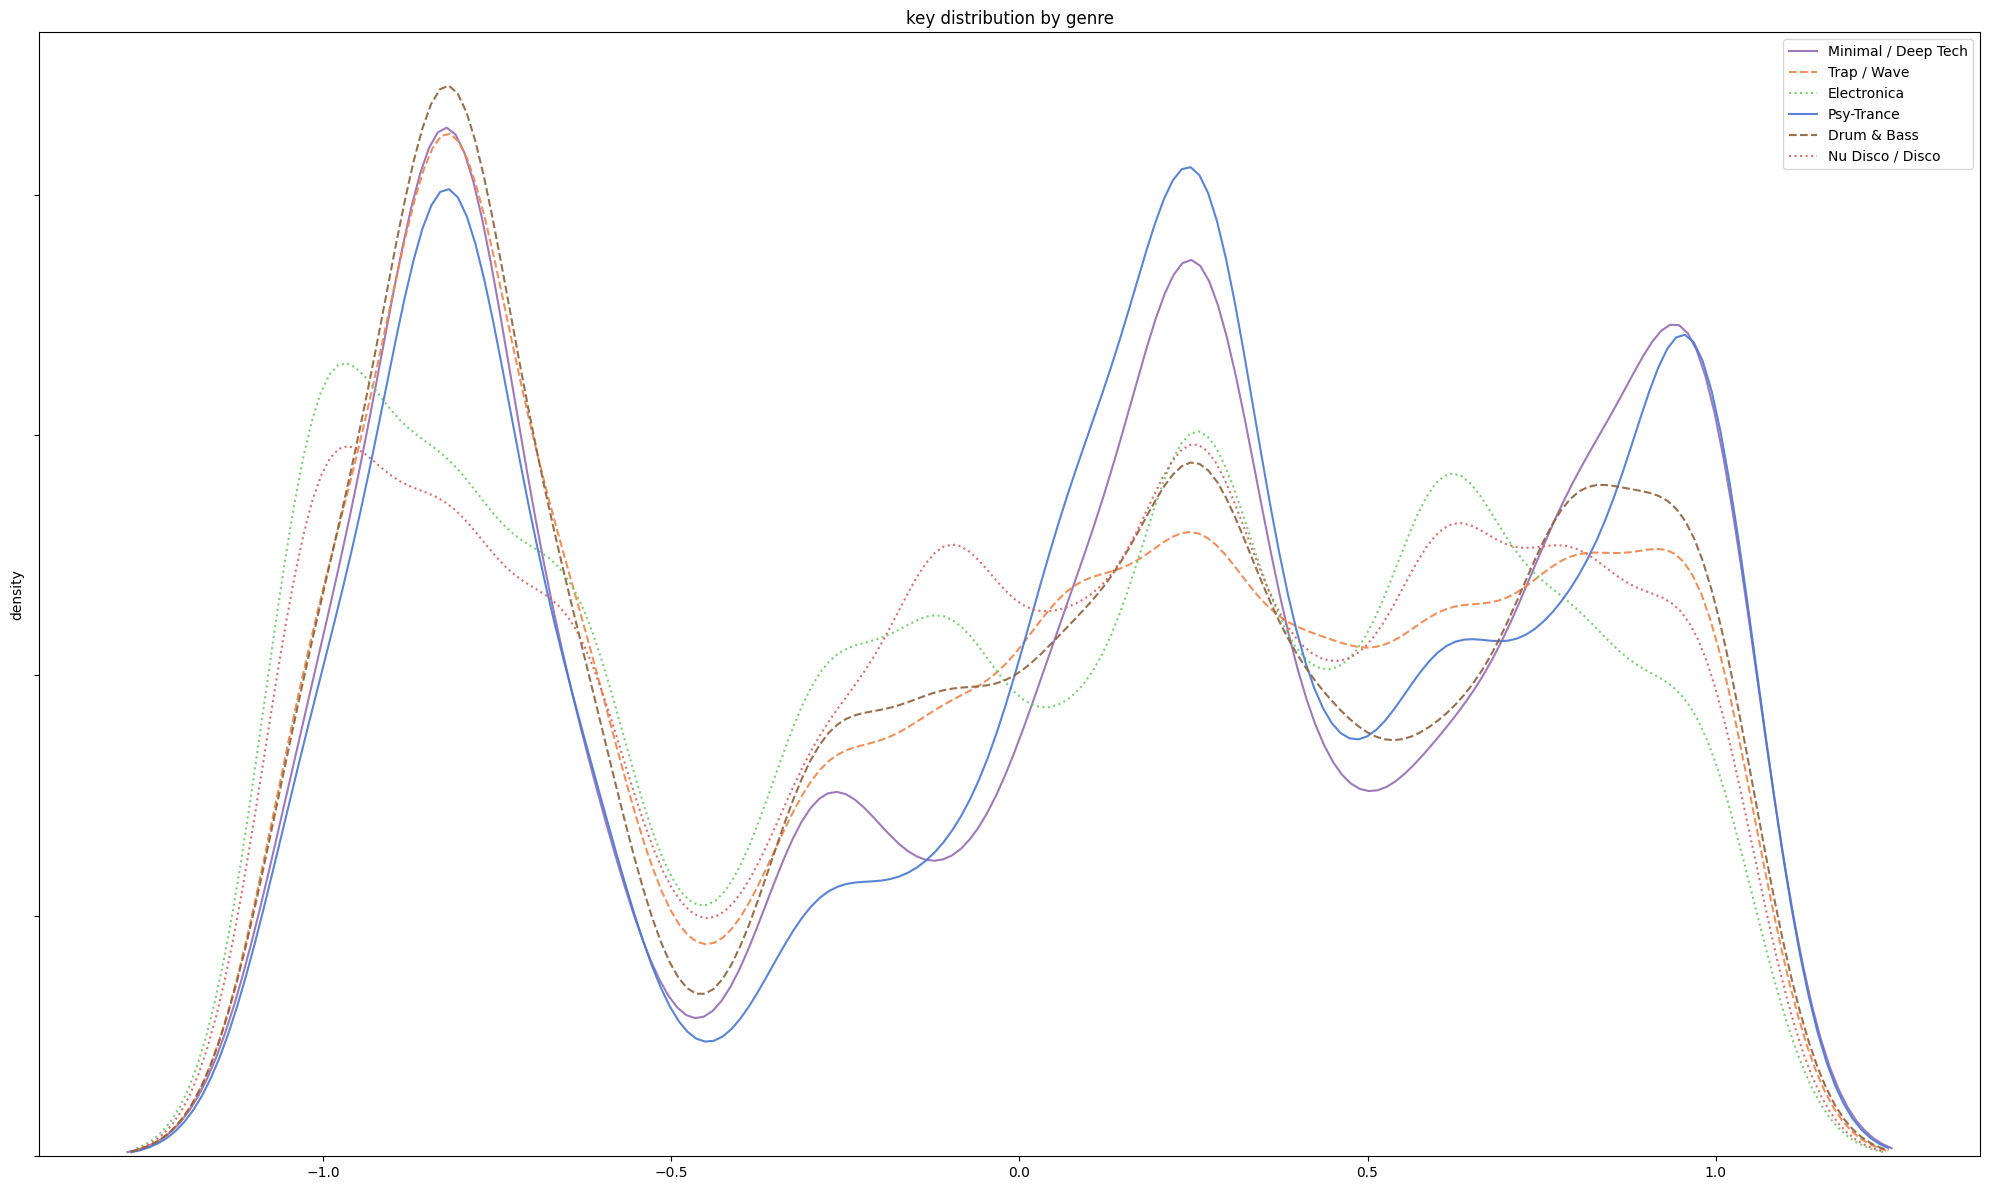

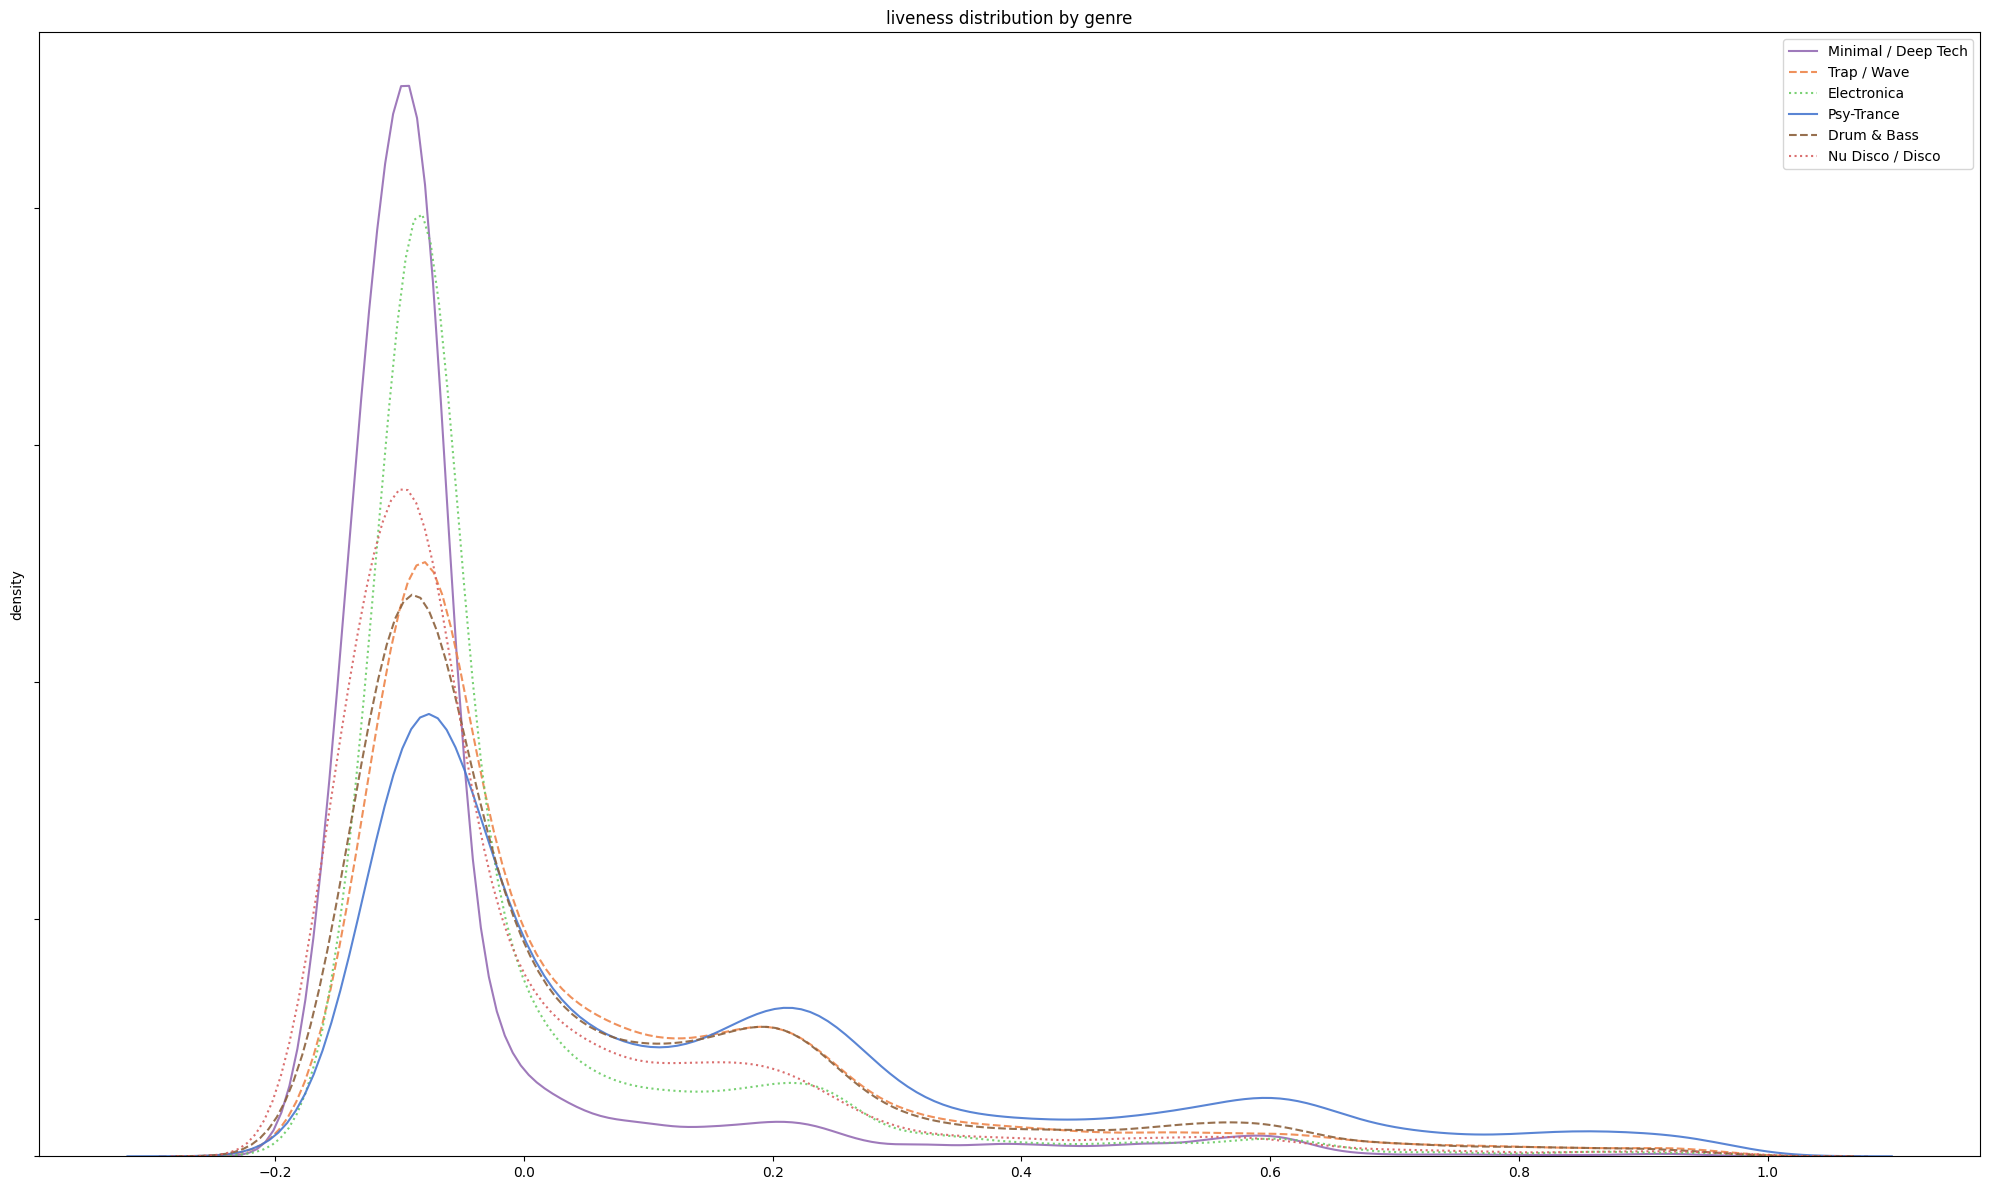

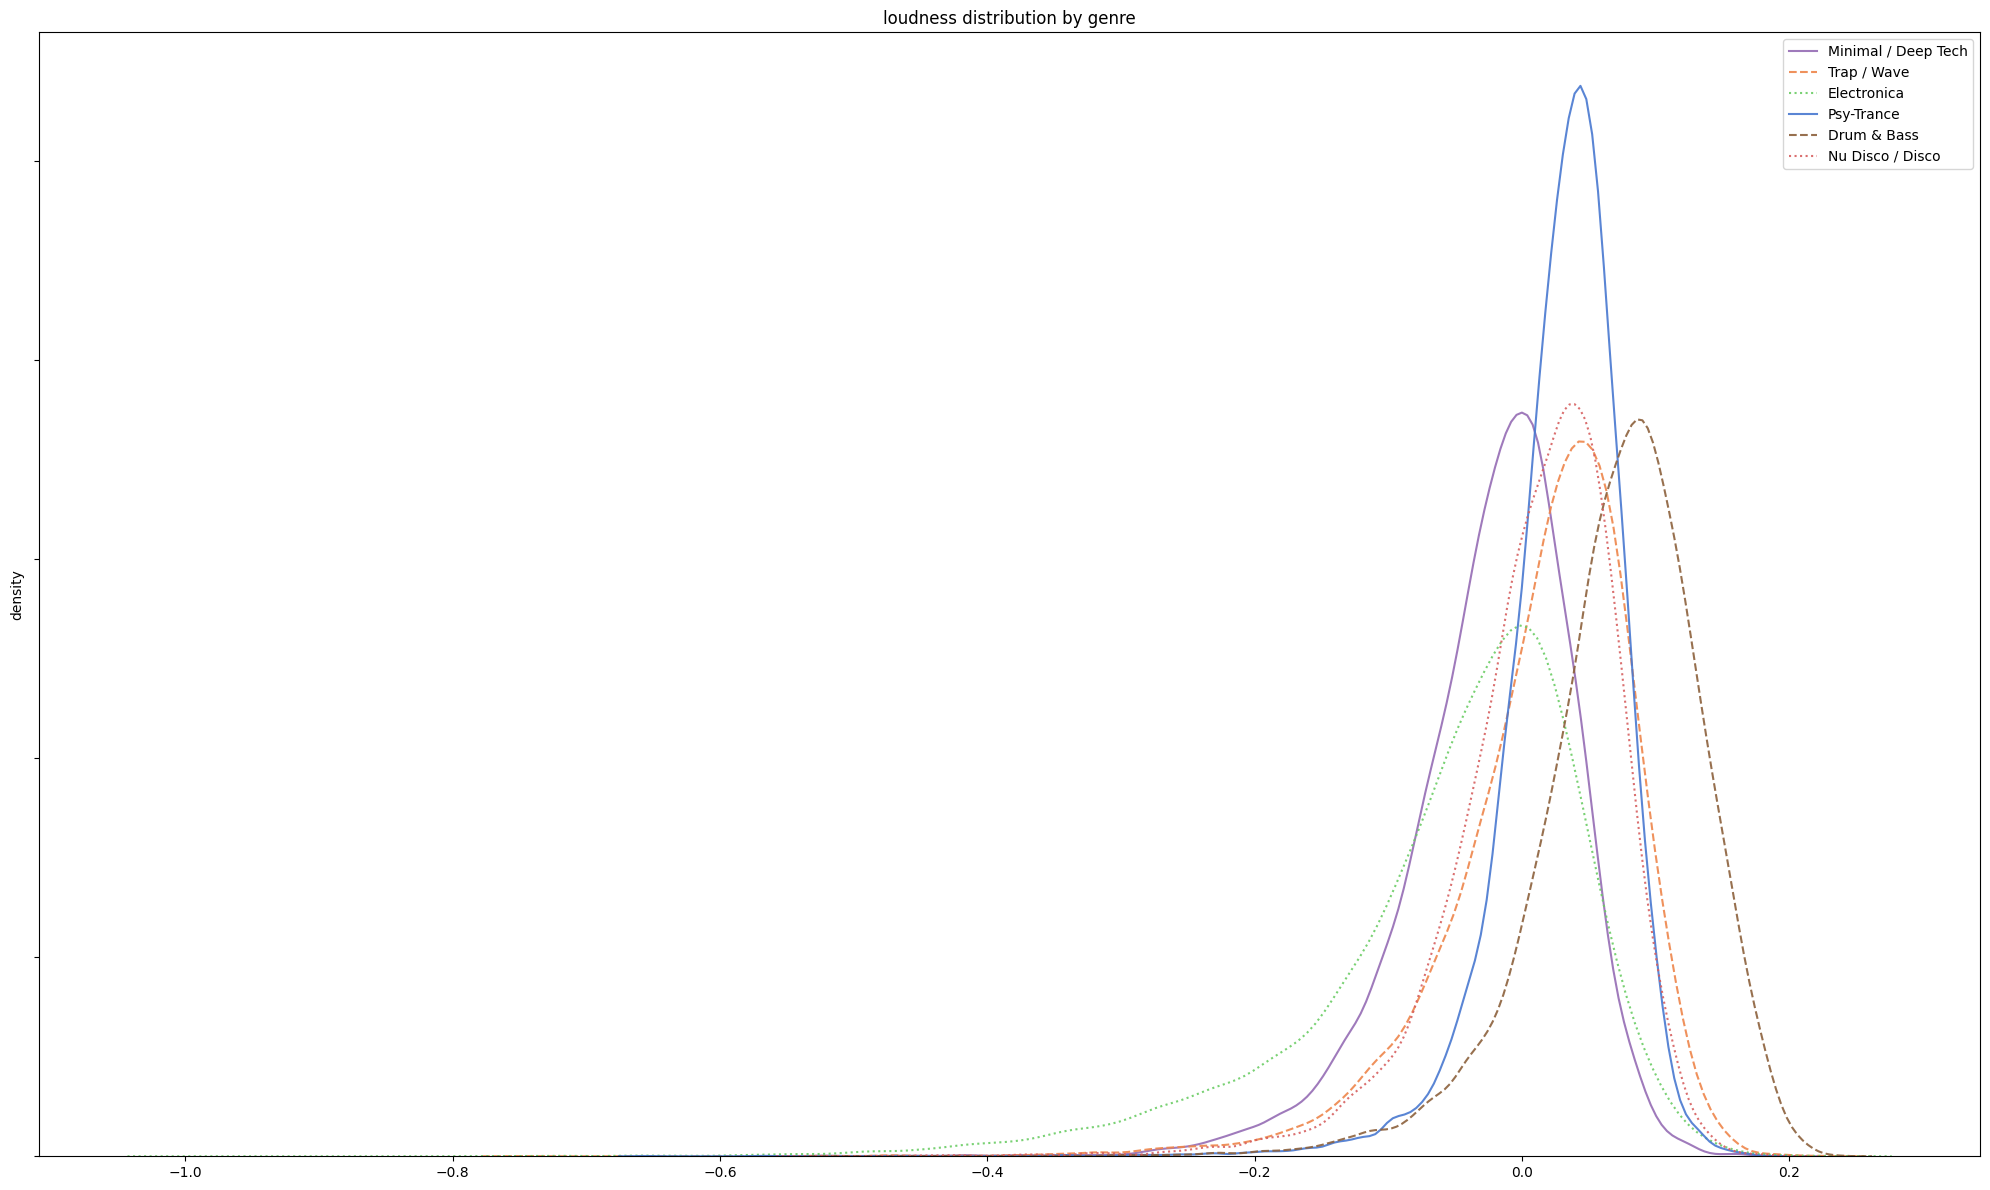

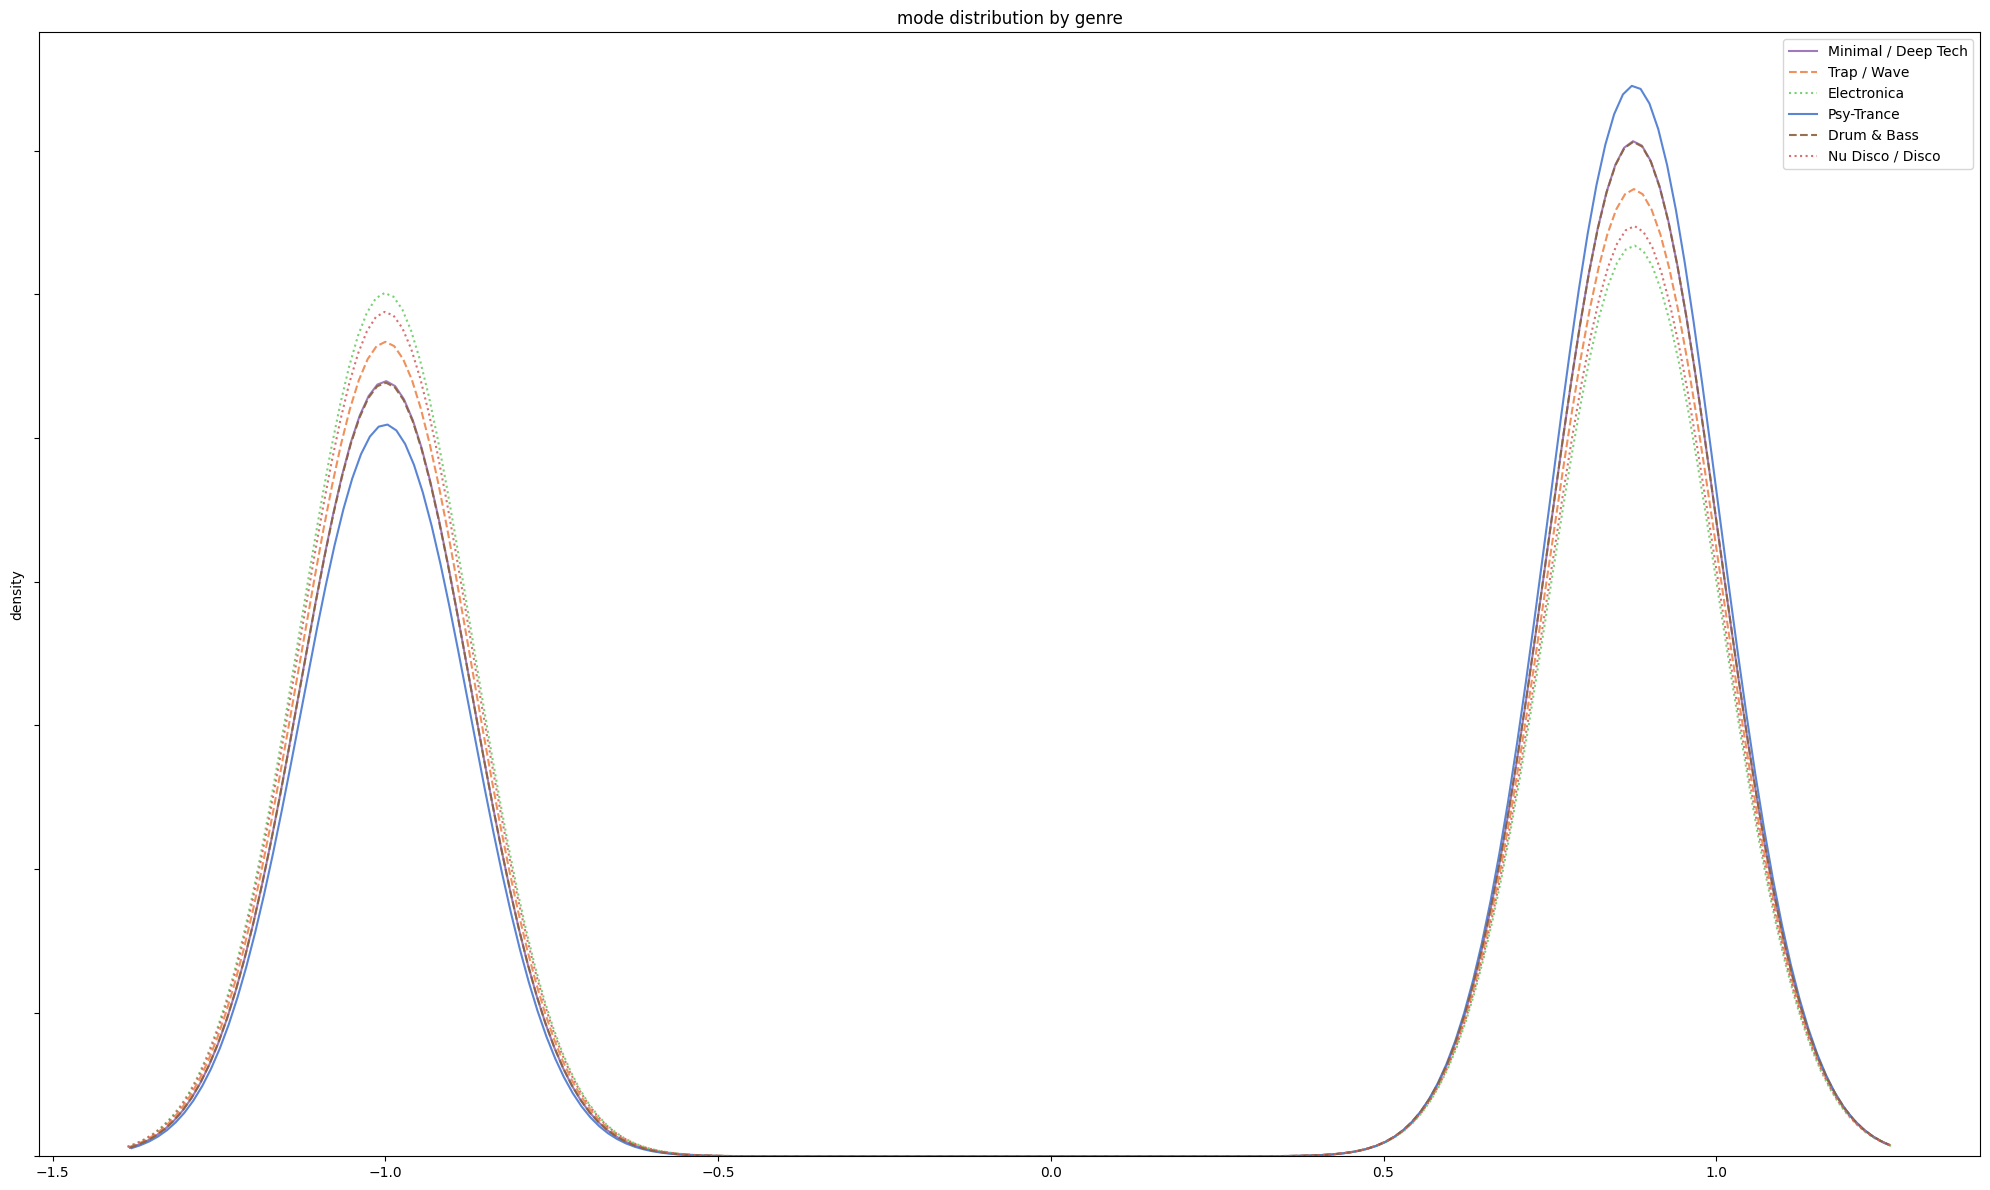

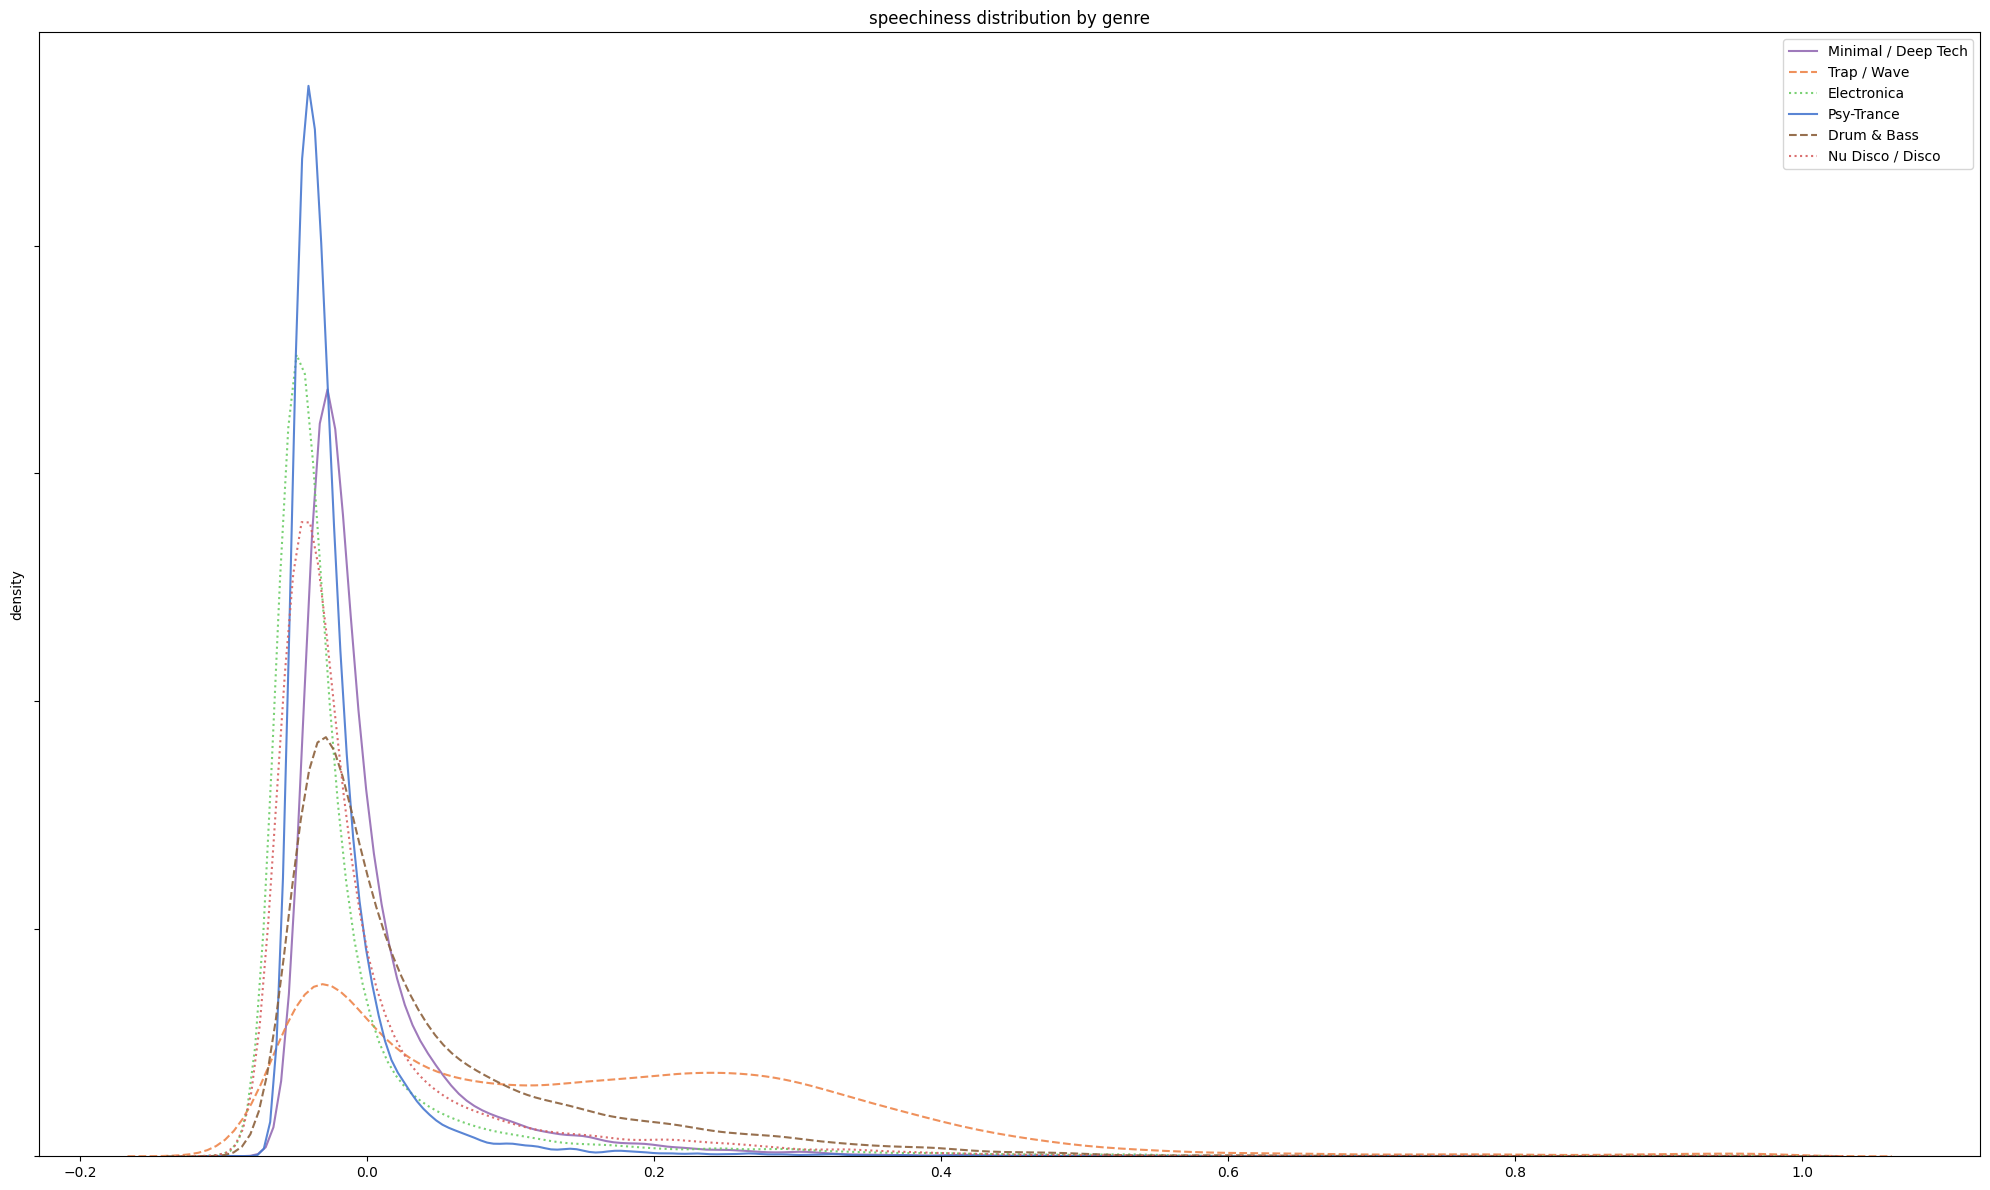

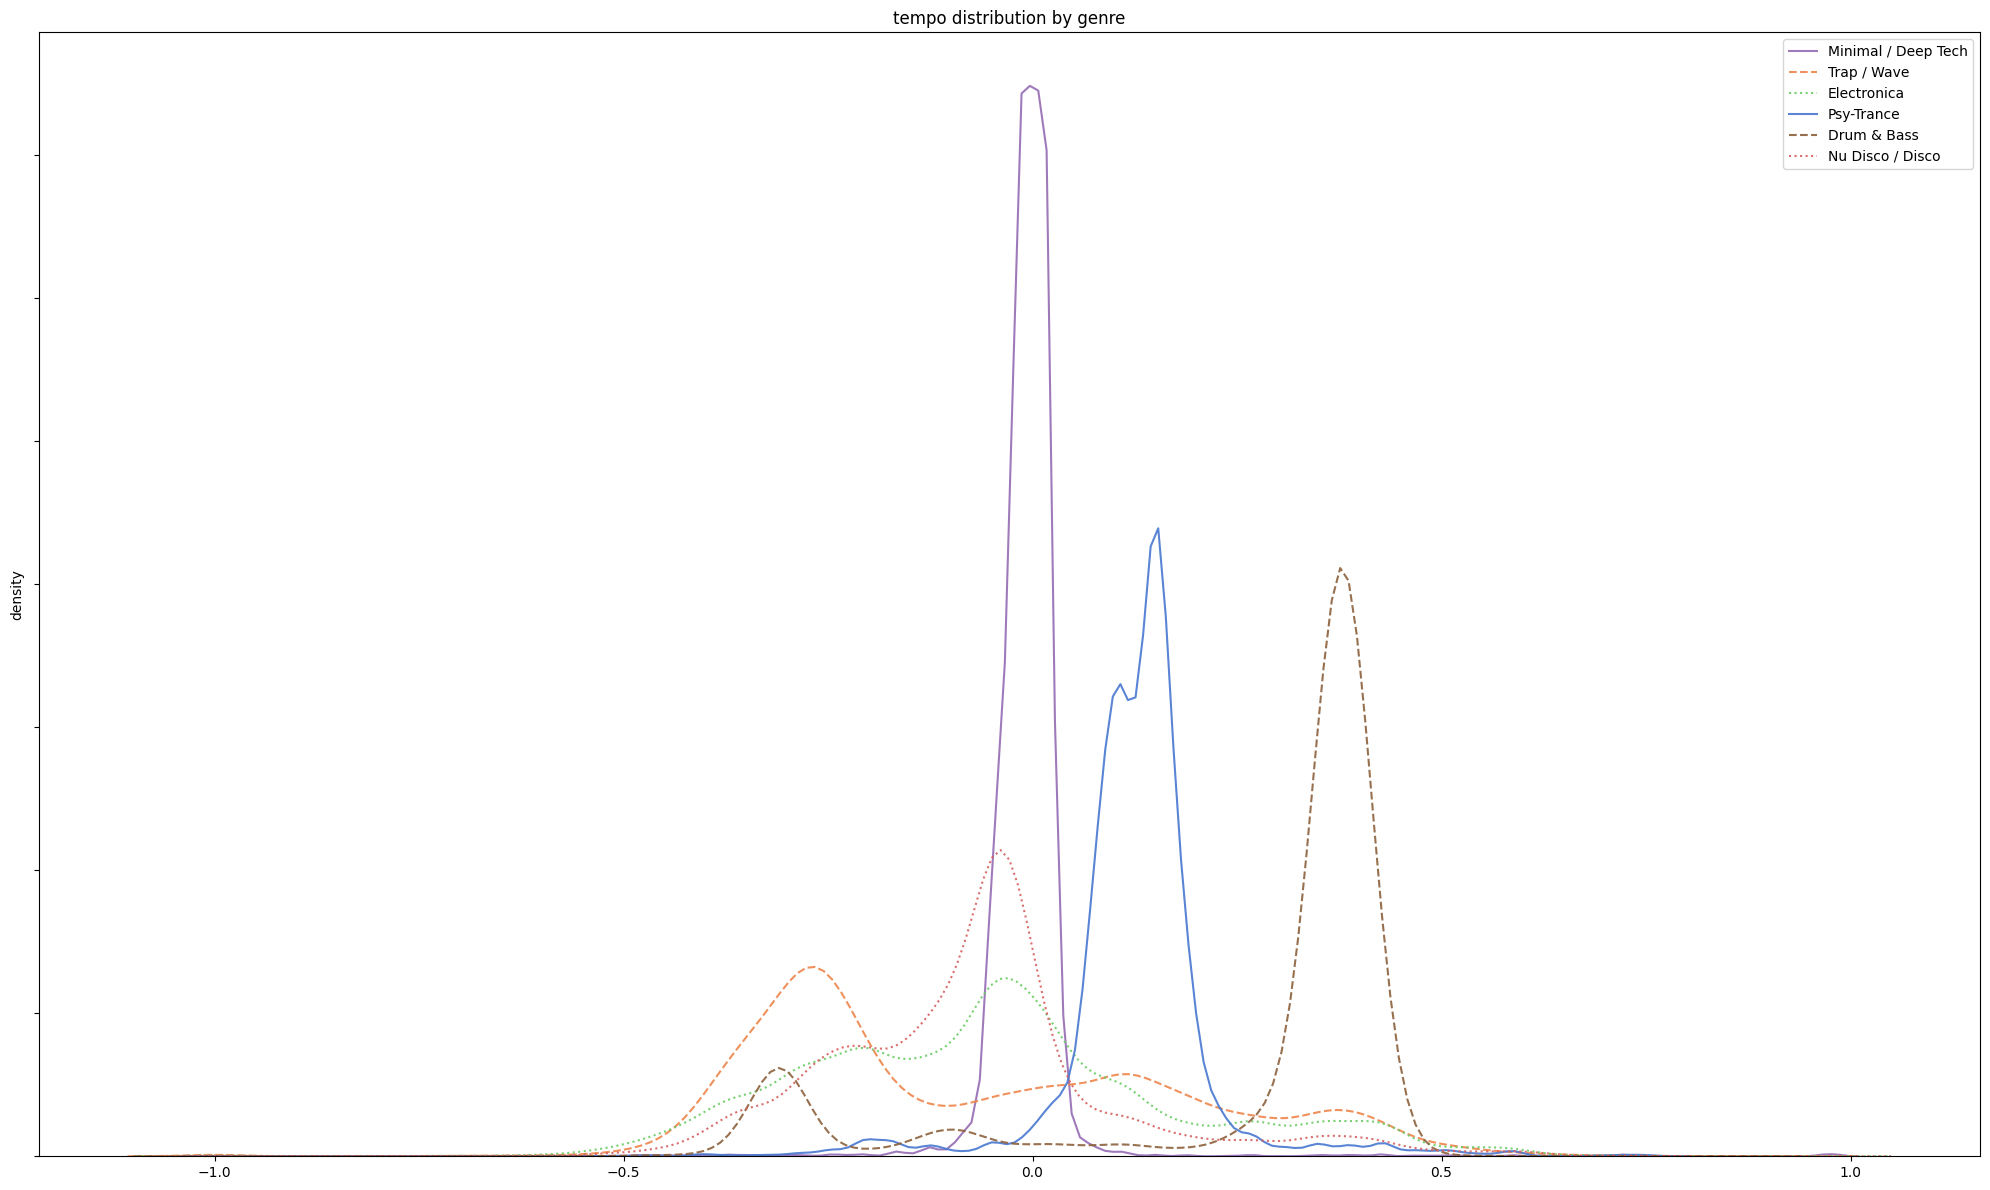

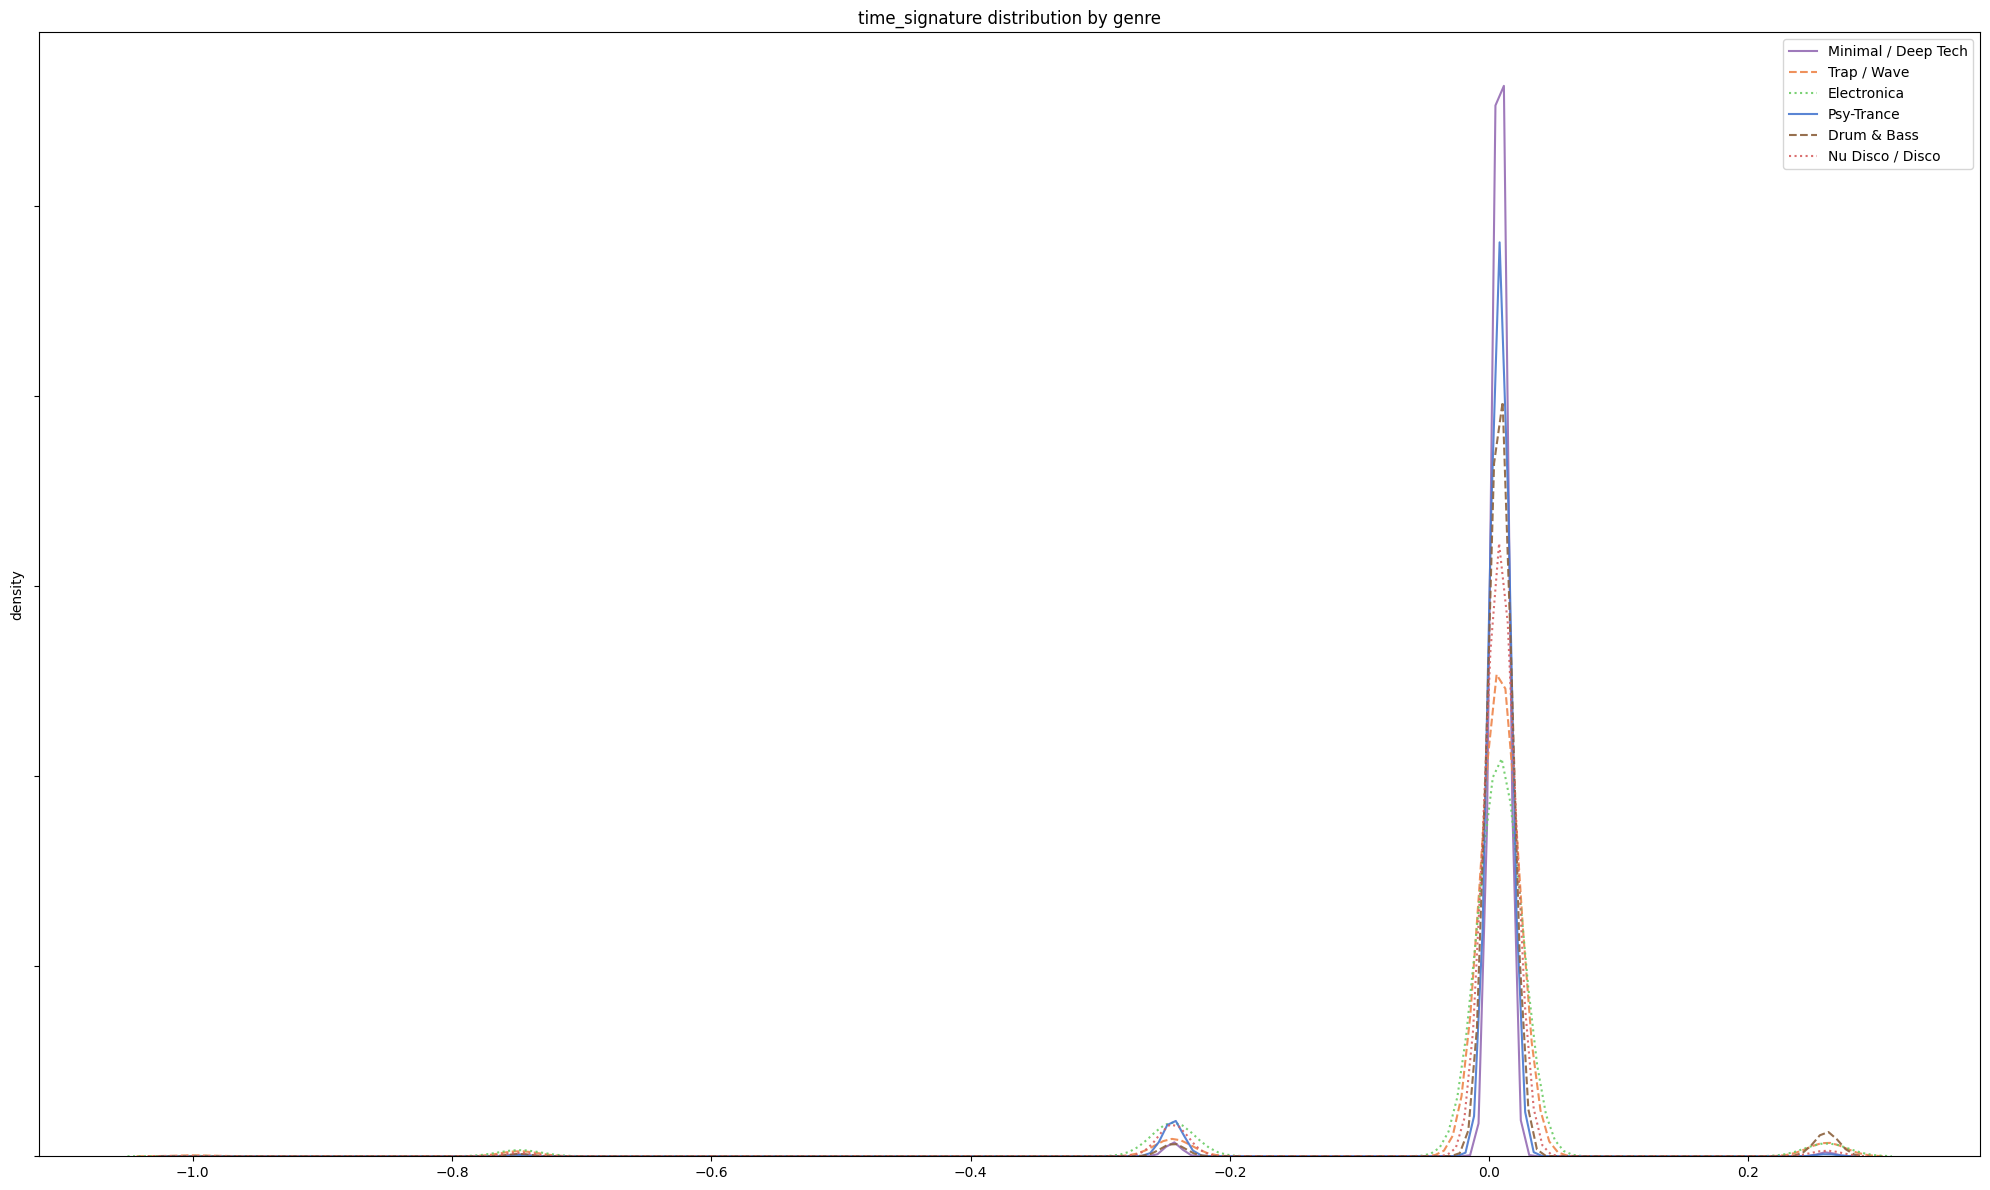

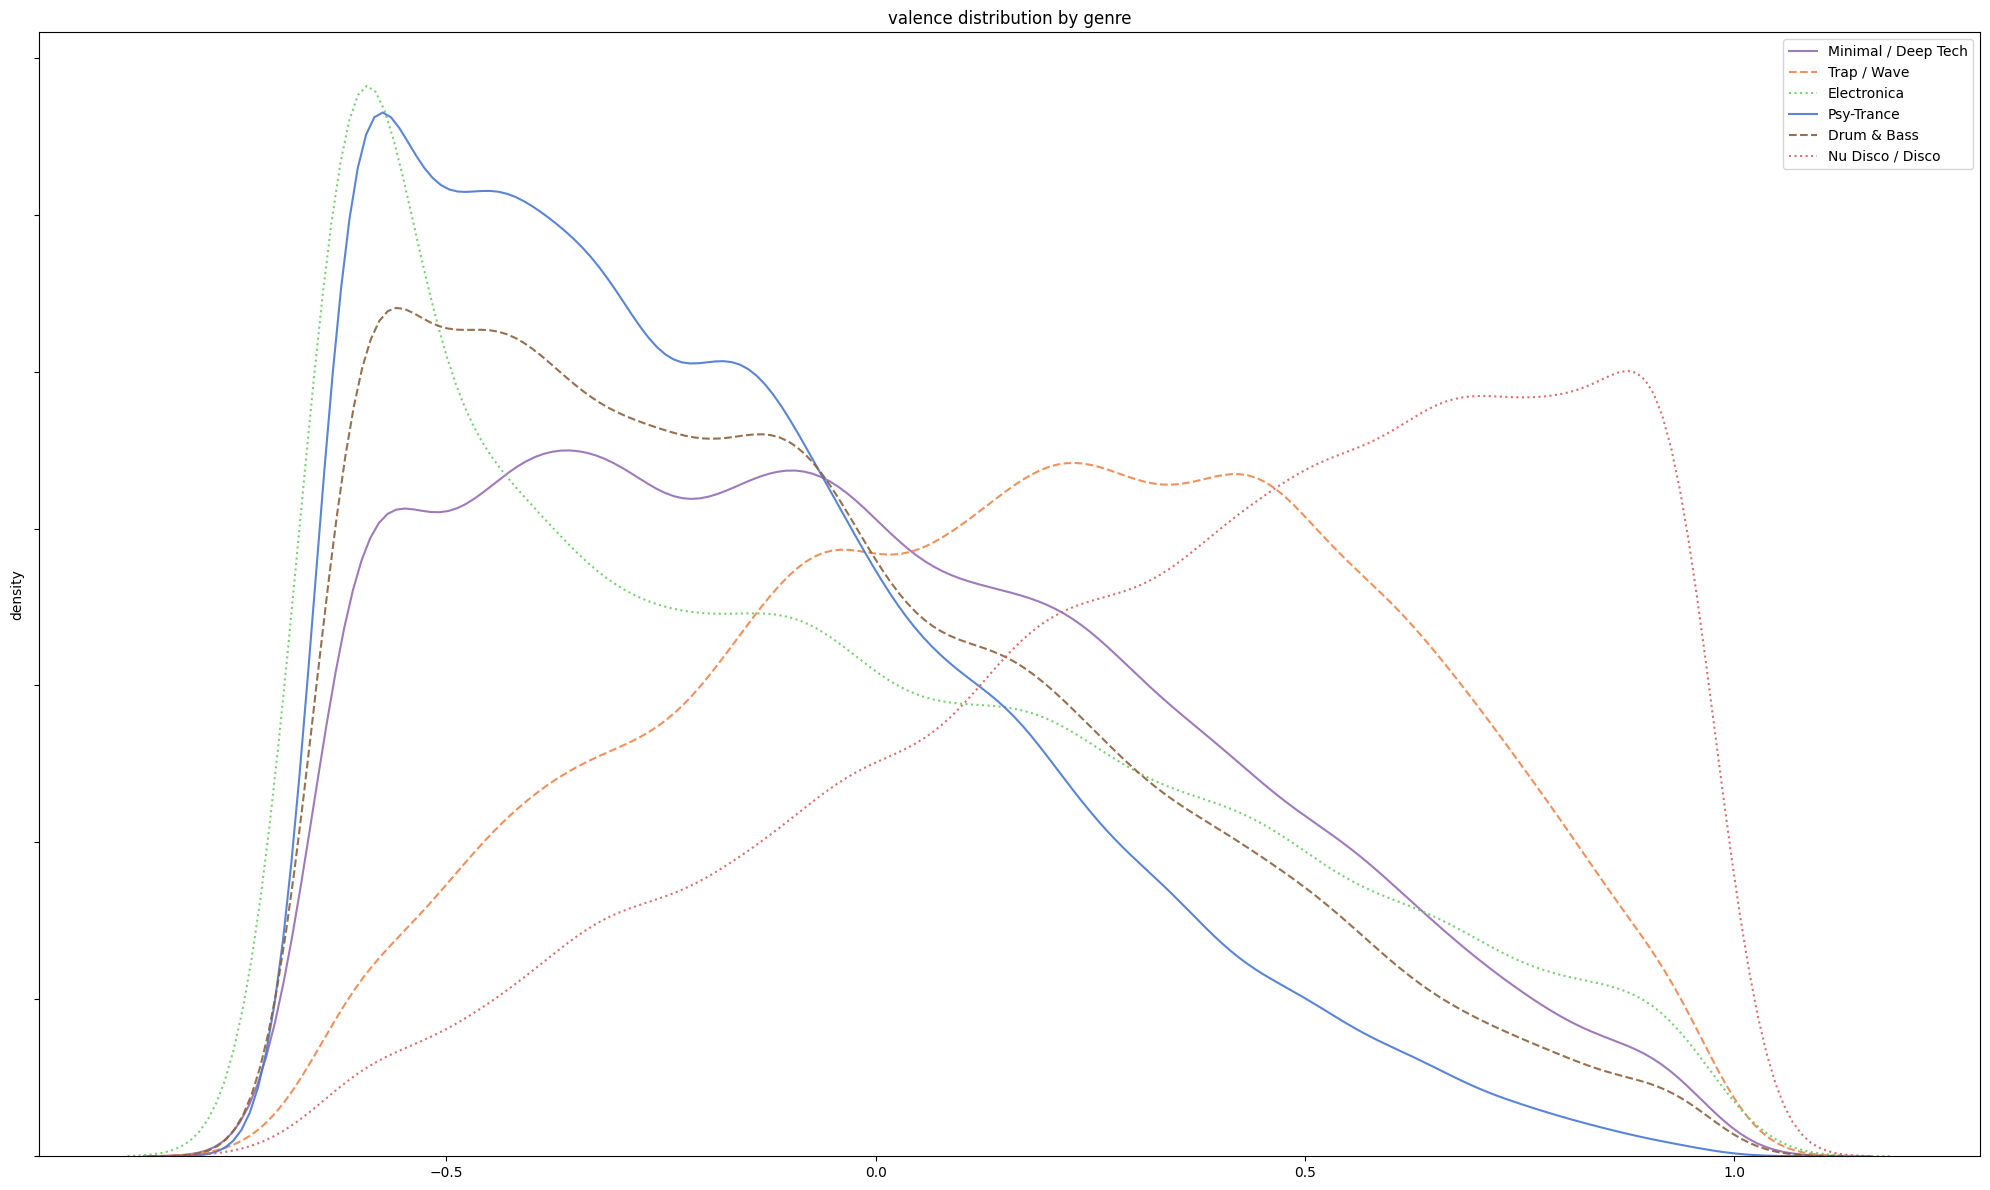

In [10]:

for feature in features:
    # Create a figure
    plt.figure(figsize=(20, 12))
    
    # Loop over distinct genres
    for index , (color , genre) in enumerate(zip(hex_colors ,genres)):
        # Filter the DataFrame for the current genre
        genre_data = features_genre_df.filter(features_genre_df["genre"] == genre)
        
        # Extract the feature data for the current genre
        feature_data = genre_data.select(feature).rdd.flatMap(lambda x: x).collect()
        
        # Plot the KDE plot for the current genre
        lineType = "-"
        if index % 3 == 1:
            lineType = "--"
        elif index % 3 == 2:
            lineType = ":"
        sns.kdeplot(data=feature_data, alpha=0.9, common_norm=False, label=genre , color=color , linestyle=lineType)
    
    # Set title and labels
    plt.title(f"{feature} distribution by genre")
    plt.xlabel("")
    plt.ylabel("density")
    plt.gca().set_yticklabels([])
    
    # Show legend
    plt.legend()
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

In [ ]:
features_genre_df.write.csv("120k",header=True)